In [373]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
from brian2.units import *
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML

In [374]:
!pwd

/c/WinPython-64bit-2.7.9.4/notebooks


In [375]:
# files = !cd provenance & ls *.txt
files =  !ls *.txt
print files

['0_1_10.txt', '0_1_11.txt', '0_1_12.txt', '0_1_2.txt', '0_1_3.txt', '0_1_4.txt', '0_1_5.txt', '0_1_6.txt', '0_1_7.txt', '0_1_8.txt', '0_1_9.txt']


In [376]:
open_files = []
eof = []
for f in files:
    open_files.append(open(f, "r"))  
    eof.append(False)
print len(open_files), "files"

11 files


In [377]:
post_ids = []
pre_app_pops = []
pre_subpops = []
pre_ids = []

global_pre_id = []
global_post_id = []
distance_sq = []

elim_prob = []
removals = []
form_prob = []
formations = []

rem_fails = []
form_fails = []

files_based_removals = {}
files_based_formations = {}

sr_attempts = []
oob= []
dist_sq_control = []

errors = {}

In [378]:
for i in range(len(open_files)):
    files_based_removals[i] = []
    files_based_formations[i] = []
    for line in open_files[i]:
        if not line:
            eof[i] = True
        spleet = str.split(line)
        if "presynaptic subpopulation" in line:
            post_ids.append(int(spleet[4]))
            pre_app_pops.append(int(spleet[6]))
            pre_subpops.append(int(spleet[9]))
            pre_ids.append(int(spleet[-1]))
        elif "g_distance_sq" in line:
            global_pre_id.append(int(spleet[4]))
            global_post_id.append(int(spleet[6]))
            distance_sq.append(int(spleet[8]))
            dist_sq_control.append([int(spleet[8]), int(spleet[-1])])
        elif "elim_prob" in line:
            elim_prob.append([int(spleet[5]), int(spleet[-1])])
        elif "form_prob" in line:
            form_prob.append([int(spleet[4]), int(spleet[7]), int(spleet[9])])
        elif "| RM pre" in line:
            removals.append([int(spleet[6]), int(spleet[8]), int(spleet[13]), int(spleet[-1])])
        elif "| FORM pre" in line:
            formations.append([int(spleet[6]), int(spleet[8]), int(spleet[15]), int(spleet[-1])])
        elif "| FAIL POT" in line or "| FAIL DEP" in line: 
            rem_fails.append(int(spleet[-1]))
            files_based_removals[i].append(int(spleet[-1]))
        elif "| NO FORM" in line:
            form_fails.append(int(spleet[-1]))
            files_based_formations[i].append(int(spleet[-1]))
        elif "sr_attempt" in line:
            sr_attempts.append([int(spleet[4]), int(spleet[5]), int(spleet[7])])  
        
        if "| OOB" in line:
            oob.append([int(spleet[5]), int(spleet[6]), int(spleet[7])])
            form_fails.append(int(spleet[6]))
            
        if "ERROR" in line:
            if len(sr_attempts)> 0:
                if line not in errors:
                        errors[line] = [sr_attempts[-1][0]]
                else:
                        errors[line].append(sr_attempts[-1][0])
            else:
                if line not in errors:
                        errors[line] = 1
                else:
                        errors[line] += 1

In [379]:
for f in open_files:
    f.close()

In [380]:
# errors

sr_attempts = np.asarray(sr_attempts)
sr_attempts.shape

(300000L, 3L)

In [381]:
post_ids = np.asarray(post_ids)
pre_app_pops = np.asarray(pre_app_pops)
pre_subpops = np.asarray(pre_subpops)
pre_ids = np.asarray(pre_ids)

global_pre_id = np.asarray(global_pre_id)
global_post_id = np.asarray(global_post_id)
distance_sq = np.asarray(distance_sq)

rem_fails = np.asarray(rem_fails)
form_fails = np.asarray(form_fails)
sr_attempts = np.asarray(sr_attempts)

oob=np.asarray(oob)
dist_sq_control=np.asarray(dist_sq_control)

elim_prob = np.asarray(elim_prob)

In [382]:
formations = np.asarray(formations)
removals = np.asarray(removals)
sr_attempts = np.asarray(sr_attempts)

In [383]:
for key in errors.keys():
    print key, len(errors[key])

[ERROR]   (topographic_map_impl.c: 491): FAIL Search
21


(array([ 0.]), array([ 0.,  1.]), <a list of 1 Patch objects>)

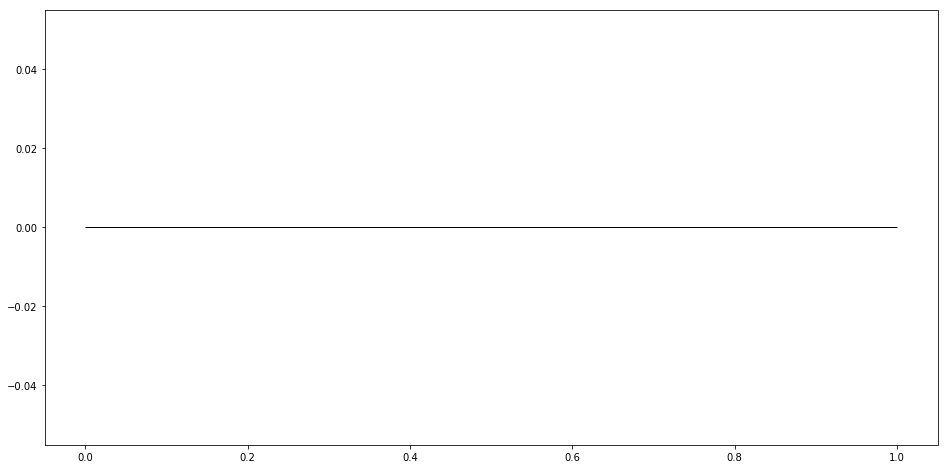

In [240]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(post_ids)
ax1.hist(post_ids, bins=d.size+1, edgecolor='black')

ValueError: `bins` should be a positive integer.

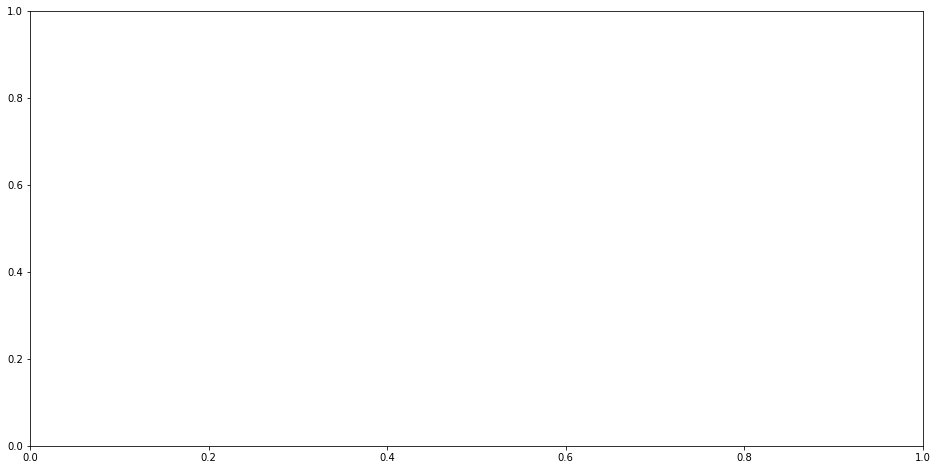

In [241]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(pre_ids)
ax1.hist(pre_ids, bins=d.size, edgecolor='black')

ValueError: zero-size array to reduction operation maximum which has no identity

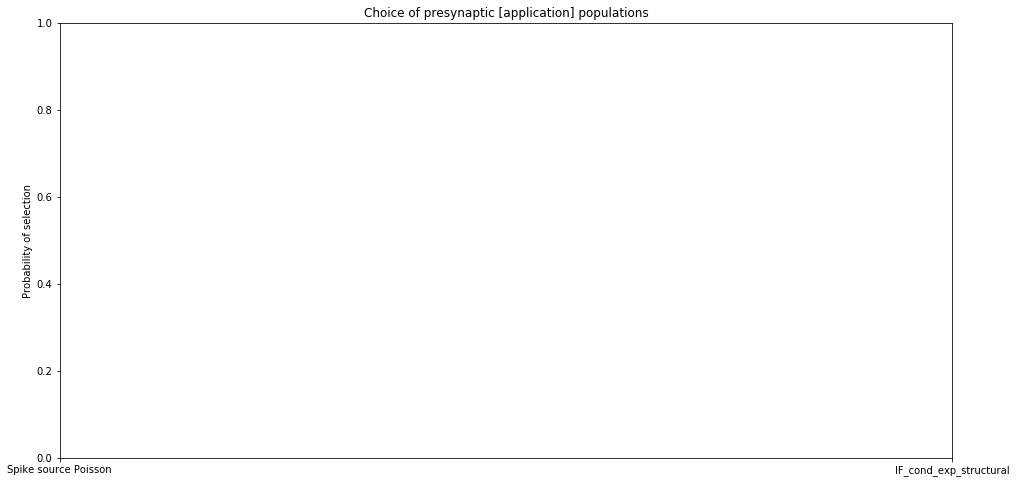

In [242]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Choice of presynaptic [application] populations")
plt.xticks([0, 2], ["Spike source Poisson", "IF_cond_exp_structural"])
ax1.set_ylabel("Probability of selection")
d = np.unique(pre_app_pops*2)
ax1.hist(pre_app_pops*2, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

ValueError: zero-size array to reduction operation maximum which has no identity

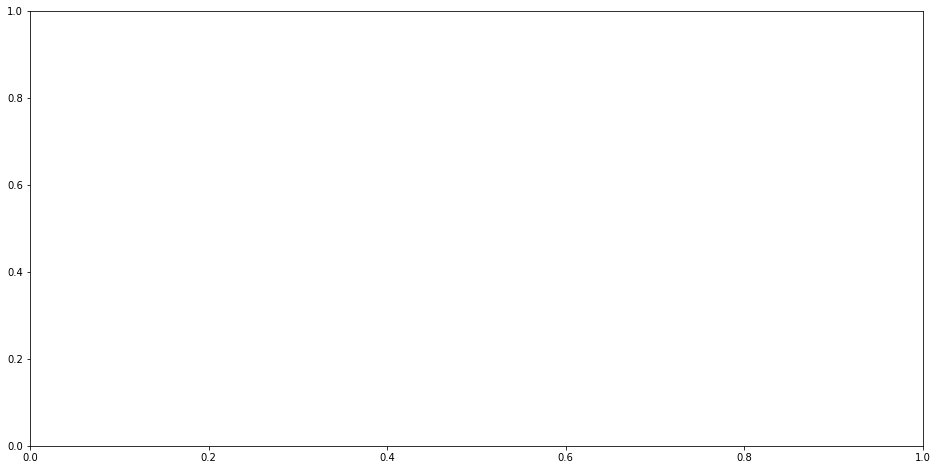

In [243]:
# combine presynaptic app with subpop
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
combo = pre_app_pops * 20 + pre_subpops

d = np.unique(combo)
ax1.hist(combo, bins=np.arange(np.max(combo)+2)-.5, edgecolor='black')
ax1.set_xlabel("Spike source Poisson {:110s} IF_cond_exp_structural".format(' '))
plt.xticks(np.concatenate((np.unique(combo[combo < np.mean(combo)]), np.unique(combo[combo > np.mean(combo)]))), np.concatenate((np.unique(combo[combo < np.mean(combo)]), np.unique(combo[combo > np.mean(combo)])-np.min(combo[combo > np.mean(combo)]))))

ValueError: `bins` should be a positive integer.

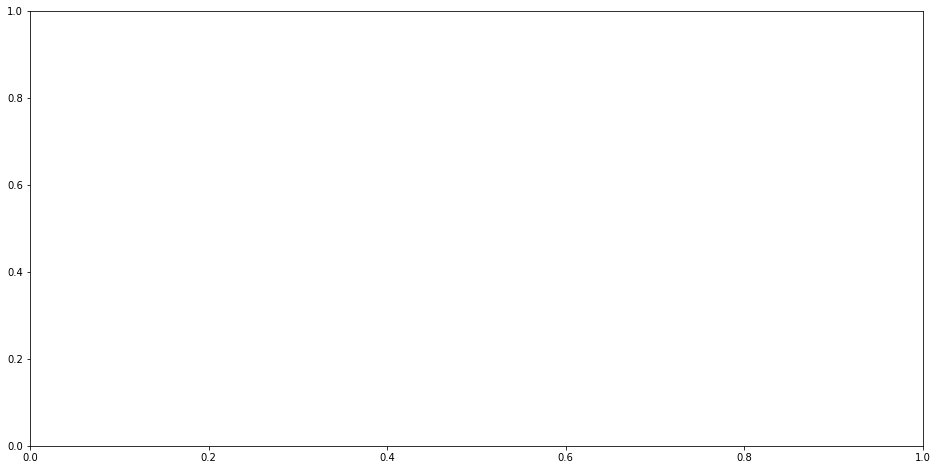

In [341]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(pre_subpops)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(pre_subpops, bins=d.size, edgecolor='black')

In [342]:
data = np.asarray(pre_subpops)

In [343]:
data[data==0].size

0

In [344]:
data[data==1].size

0

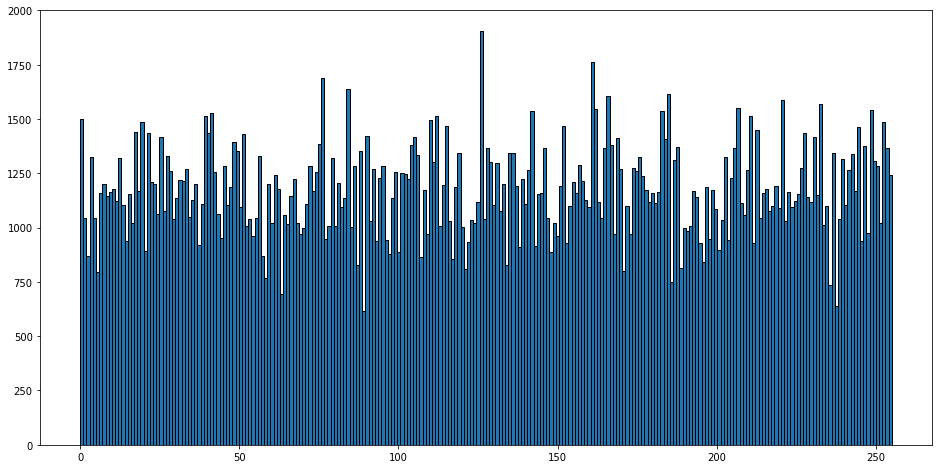

In [384]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(global_pre_id)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(global_pre_id, bins=d.size, edgecolor='black')
plt.savefig("potential_partner_pre_id_16x16.png")

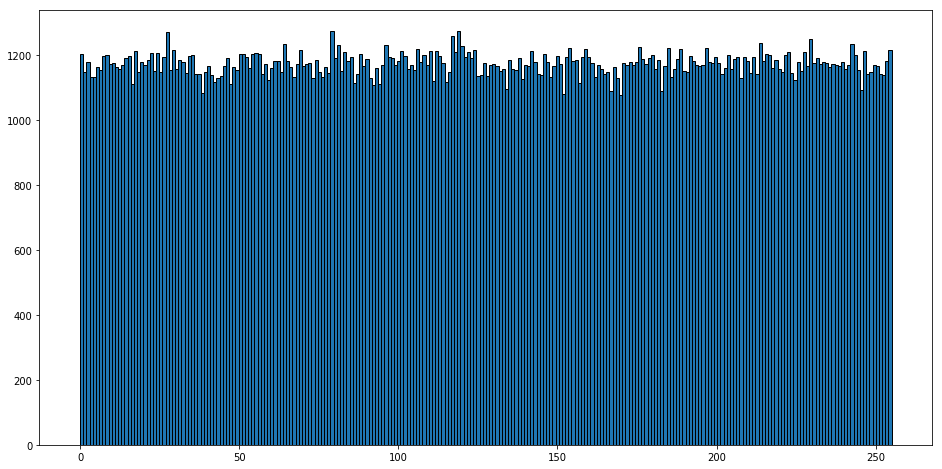

In [385]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(global_post_id)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(global_post_id, bins=d.size, edgecolor='black')
plt.savefig("global_post_ids_16x16.png")

(array([  1.62990625e-01,   6.50343750e-02,   1.81715625e-02,
          1.71675000e-02,   1.18704687e-02,   1.74081250e-02,
          7.69125000e-03,   0.00000000e+00,   1.15445313e-02,
          3.32390625e-03,   1.11343750e-03,   2.72453125e-03,
          1.51593750e-03,   2.74968750e-03,   6.26718750e-04,
          0.00000000e+00,   1.73687500e-03,   1.07078125e-03,
          0.00000000e+00,   3.60937500e-04,   1.80468750e-04,
          3.48906250e-04,   8.09375000e-05,   1.15937500e-04,
          1.40000000e-04,   0.00000000e+00,   1.31250000e-05,
          5.03125000e-05,   0.00000000e+00,   5.25000000e-05,
          0.00000000e+00,   0.00000000e+00,   2.62500000e-05,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   9.84375000e-06,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.46875000e-06]),
 array([   0.        ,    3.04761905,    6.0952381 ,    9.14285714,
          12.19047619,   15.23809524,   18.28571429,   21.3333

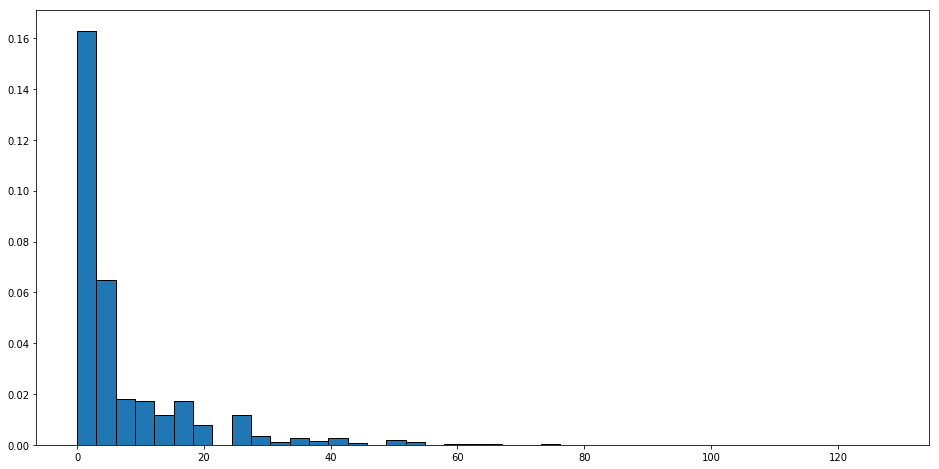

In [386]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(distance_sq)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
ax1.hist(distance_sq, bins=d.size,edgecolor='black', normed=1)

In [387]:
dist = np.sqrt(distance_sq)
m = np.mean(dist)
std = np.std(dist)

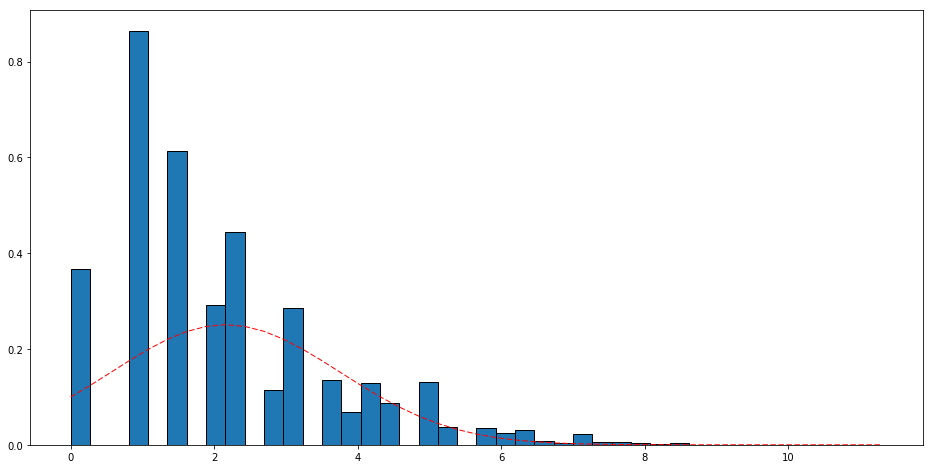

In [388]:
import matplotlib.mlab as mlab
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(np.sqrt(distance_sq))
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

n, bins, patches = ax1.hist(np.sqrt(distance_sq), bins=d.size,normed=1, edgecolor='black')
y = mlab.normpdf( bins, m, std)
l = ax1.plot(bins, y, 'r--', linewidth=1)

In [389]:
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    delta = np.where(delta > grid * .5, delta - grid, delta)

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))
def index_to_dist(i1, i2, grid):
    return distance((i1//grid[0], i1%grid[1]),(i2//grid[0], i2%grid[1]), grid=grid, type='euclidian')

In [390]:
layer_size = 256
grid_layout = np.asarray((16, 16))

In [391]:
for i in np.arange(global_post_id.size):
    assert np.round(index_to_dist(global_pre_id[i], global_post_id[i], grid_layout)**2) == distance_sq[i], \
    "{} vs {}".format(np.round(index_to_dist(global_pre_id[i], global_post_id[i], grid_layout)**2),  distance_sq[i])

In [392]:
counts = np.ones((layer_size, layer_size)) * np.nan

In [393]:
for i in np.arange(global_post_id.size):
    if np.isnan(counts[global_pre_id[i], global_post_id[i]]):
        counts[global_pre_id[i], global_post_id[i]] = 1
    else:
        counts[global_pre_id[i], global_post_id[i]] += 1

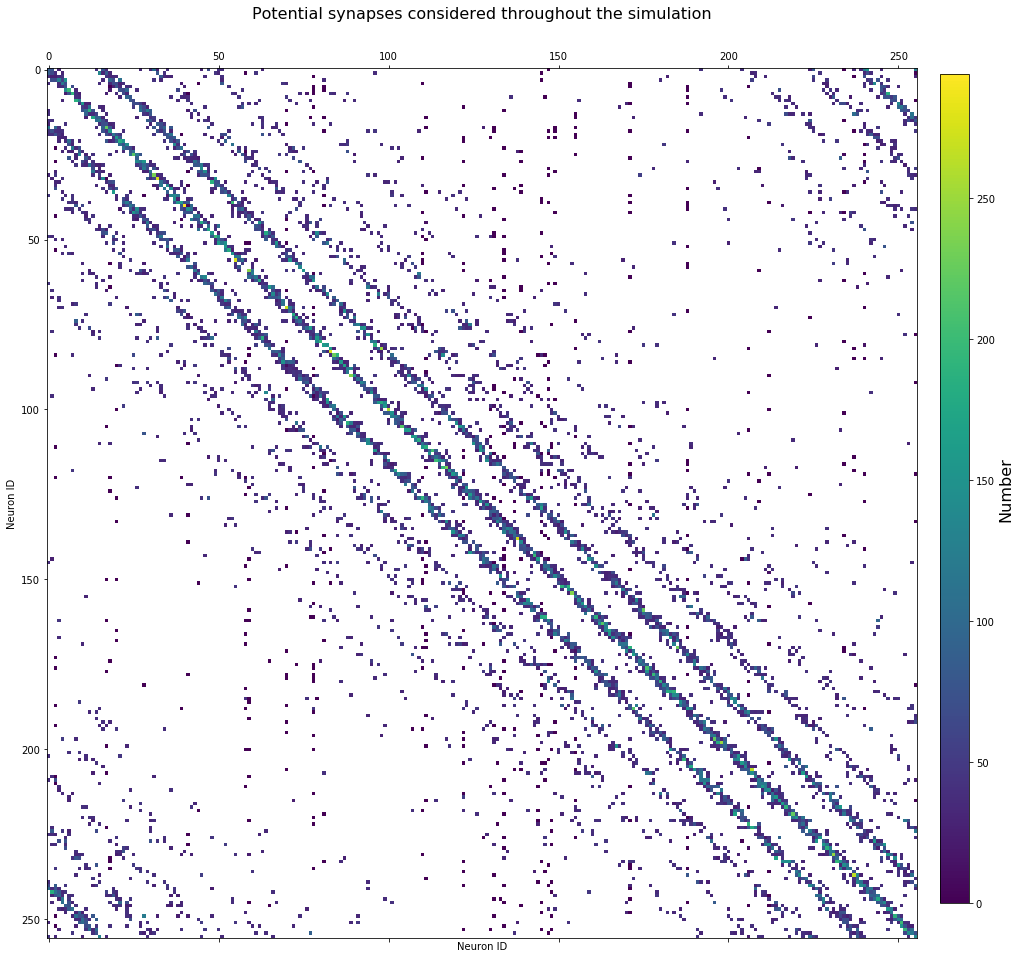

In [408]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16,16))
i = ax1.matshow(counts, vmin=0)
ax1.grid(visible=False)
ax1.set_title("Potential synapses considered throughout the simulation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# ax1.set_ylim([20, 0])
# ax1.set_xlim([0, 20])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Number", fontsize=16)
plt.savefig("global_mentions_16x16.png")

In [395]:
print "total rewire attempts", np.nansum(counts)

total rewire attempts 300000.0


In [396]:
print "hit locations", np.count_nonzero(np.isfinite(counts))

hit locations 6031


In [397]:
print "surface coverage", np.count_nonzero(np.isfinite(counts)) * 100. / counts.size 

surface coverage 9.20257568359


In [398]:
elim_prob = np.asarray(elim_prob)
removals= np.asarray(removals)
form_prob= np.asarray(form_prob)
formations = np.asarray(formations)

In [399]:
formation_counts = np.ones((layer_size, layer_size)) * np.nan
for i in np.arange(formations.shape[0]):
    if np.isnan(formation_counts[formations[i, 0], formations[i, 1]]):
        formation_counts[formations[i, 0], formations[i, 1]] = 1
    else:
        formation_counts[formations[i, 0], formations[i, 1]] += 1

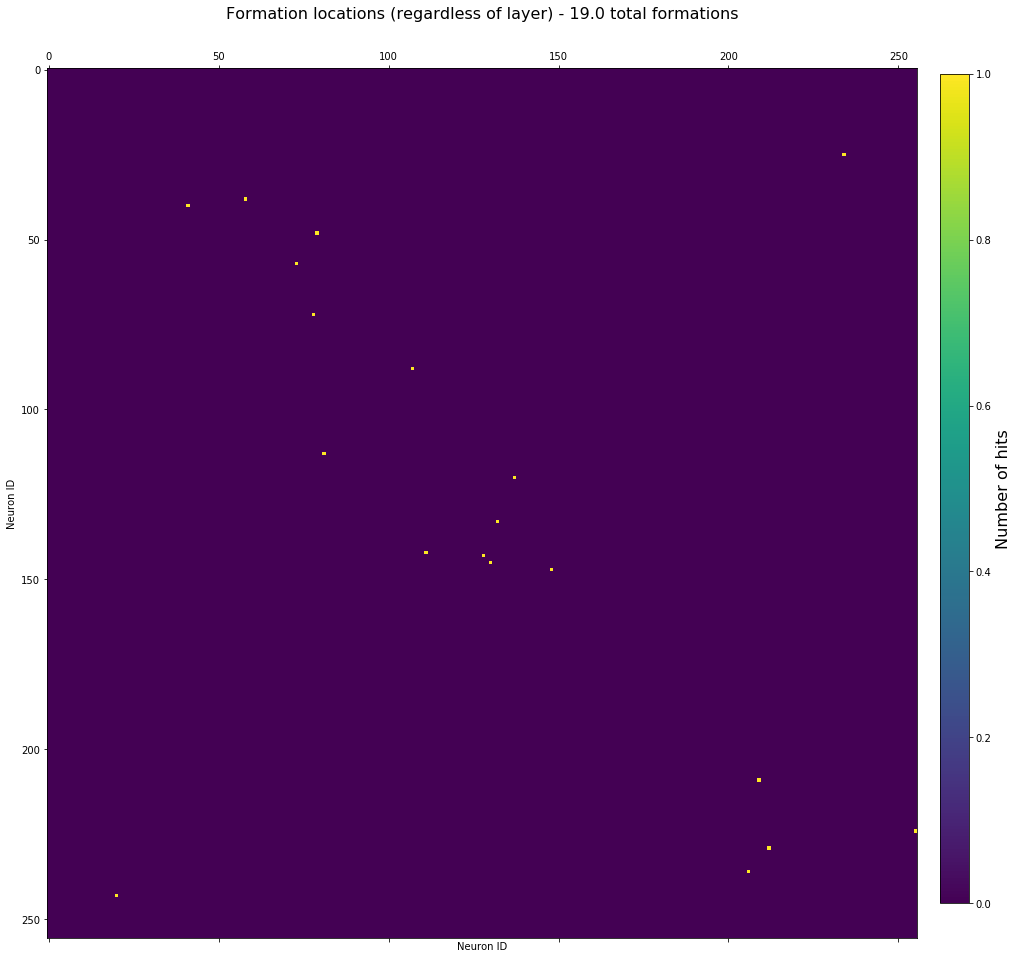

In [400]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16,16))
i = ax1.matshow(np.nan_to_num(formation_counts), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Formation locations (regardless of layer) - " 
              + str(np.sum(formation_counts[np.isfinite(formation_counts)])) 
              + " total formations" , fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# ax1.set_ylim([20, 0])
# ax1.set_xlim([0, 20])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Number of hits", fontsize=16)
plt.savefig("form_hits.png")

In [401]:
print "Total number of formations", np.sum(formation_counts[np.isfinite(formation_counts)])

Total number of formations 19.0


In [402]:
np.sum(np.isfinite(formation_counts))

19

In [403]:
deletion_counts = np.ones((layer_size, layer_size)) * np.nan
for i in np.arange(removals.shape[0]):
    if np.isnan(deletion_counts[removals[i, 0], removals[i, 1]]):
        deletion_counts[removals[i, 0], removals[i, 1]] = 1
    else:
        deletion_counts[removals[i, 0], removals[i, 1]] += 1

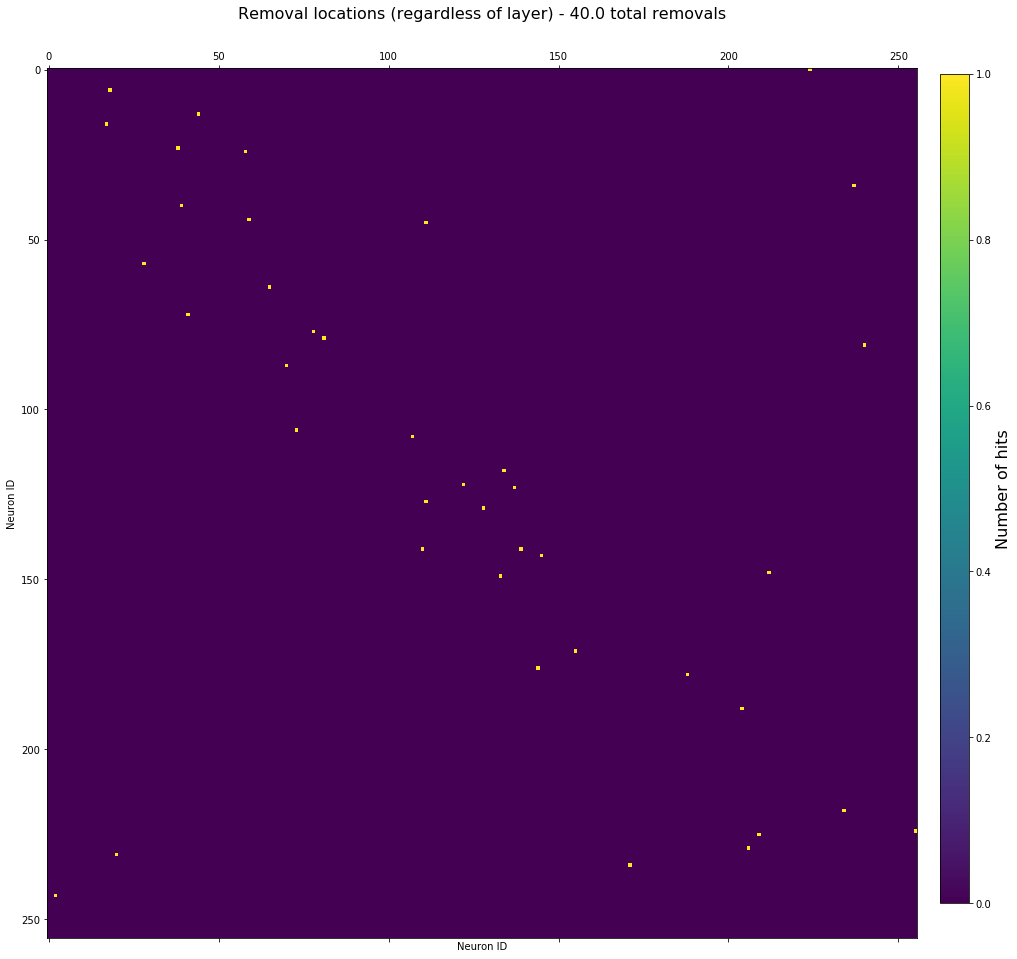

In [404]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16,16))
i = ax1.matshow(np.nan_to_num(deletion_counts), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Removal locations (regardless of layer) - " 
              + str(np.sum(deletion_counts[np.isfinite(deletion_counts)])) 
              + " total removals" , fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
# ax1.set_ylim([20, 0])
# ax1.set_xlim([0, 20])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Number of hits", fontsize=16)
plt.savefig("removal_hits.png")

In [405]:
print "Total number of removals", np.sum(deletion_counts[np.isfinite(deletion_counts)])

Total number of removals 40.0


In [406]:
np.argmax(deletion_counts[np.isfinite(deletion_counts)])

0

In [407]:
print "Cancer" 
for key in errors.keys():
    print key, len(errors[key])

Cancer
[ERROR]   (topographic_map_impl.c: 491): FAIL Search
21


In [272]:
p_elim_dep = 0.0245 * (2**32)
p_elim_pot = 1.36 * np.e ** -4 * (2**32)

IndexError: too many indices for array

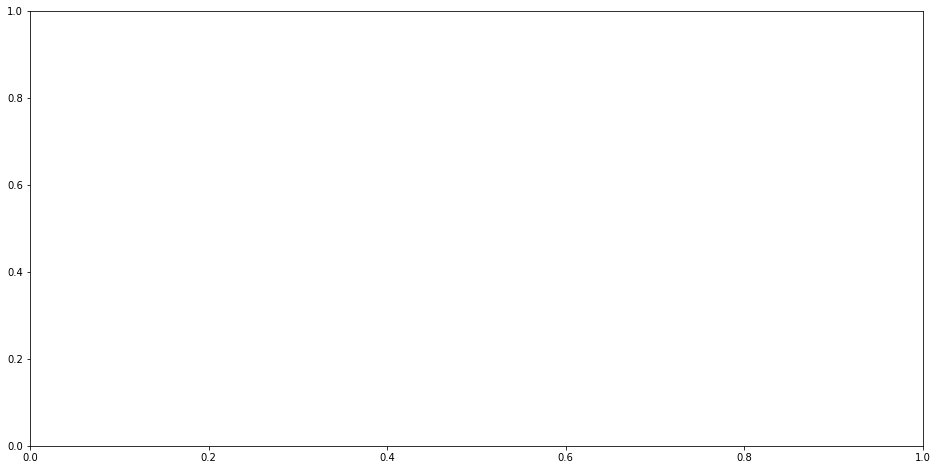

In [273]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.plot(elim_prob[:, 0])
ax1.axhline(p_elim_pot, ls='-', c='g')
ax1.axhline(p_elim_dep, ls=':', c='r')

In [49]:
print "min elim probability (uint16)", np.min(elim_prob[:,0])
print "max elim probability (uint32)", np.max(elim_prob[:,0]), "vs MAXUINT32", 2**32

min elim probability (uint16)

IndexError: too many indices for array

IndexError: too many indices for array

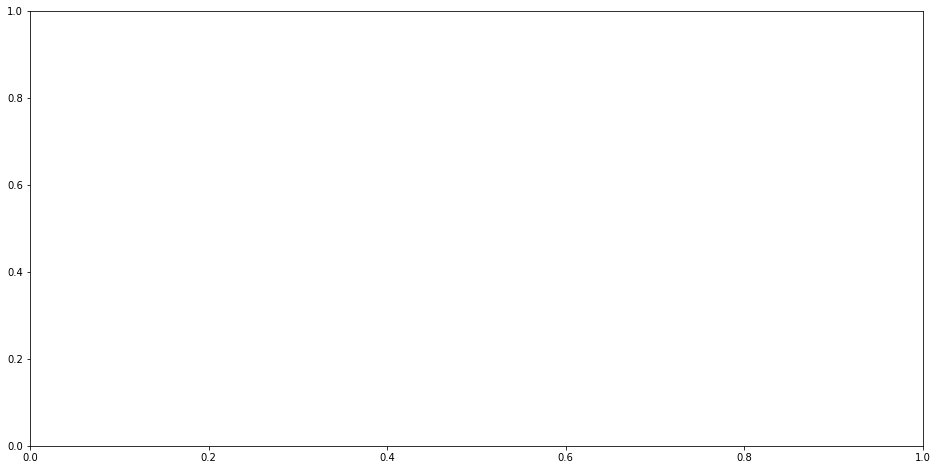

In [50]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d=np.unique(elim_prob[:,0])
ax1.hist(elim_prob[:, 0], bins=d.size, edgecolor='black', normed=1)

IndexError: too many indices for array

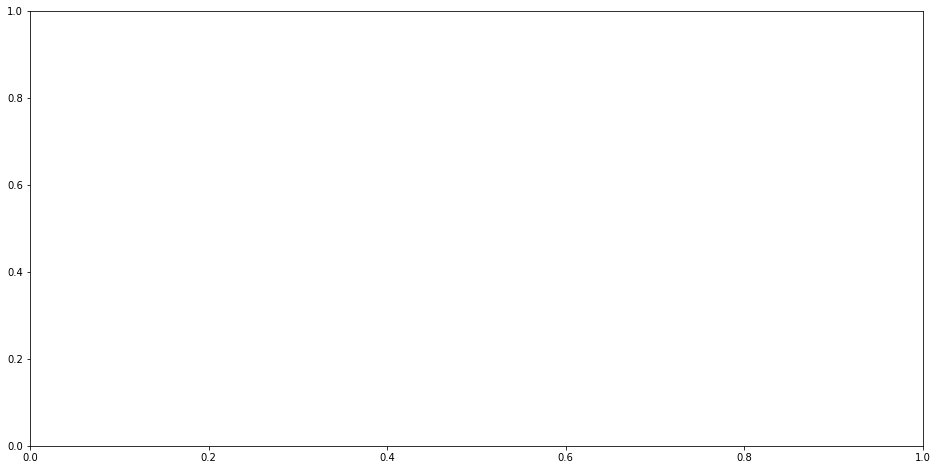

In [51]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.plot(form_prob[:, 0])

IndexError: too many indices for array

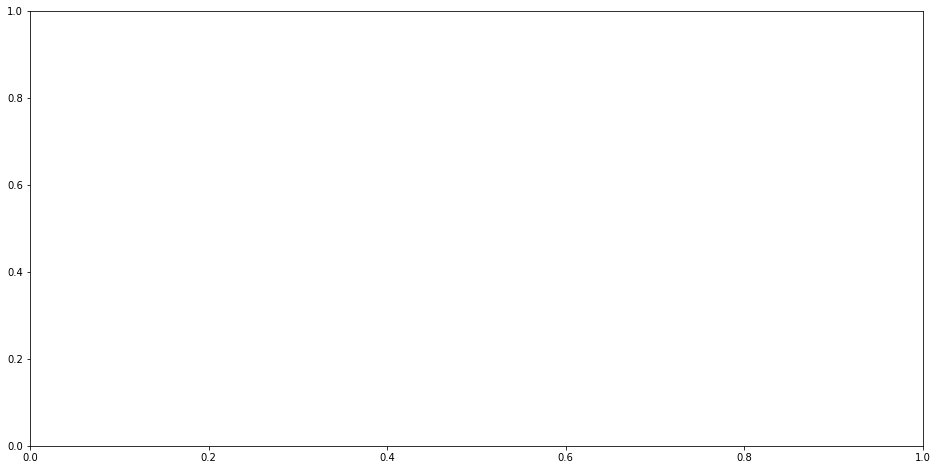

In [52]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.plot(form_prob[:, 1])

In [53]:
print "min form probability (uint16)", np.min(form_prob[:, 1])
print "max form probability (uint16)", np.max(form_prob[:, 1]), "vs MAXUINT16", 2**16-1

 min form probability (uint16)

IndexError: too many indices for array

IndexError: too many indices for array

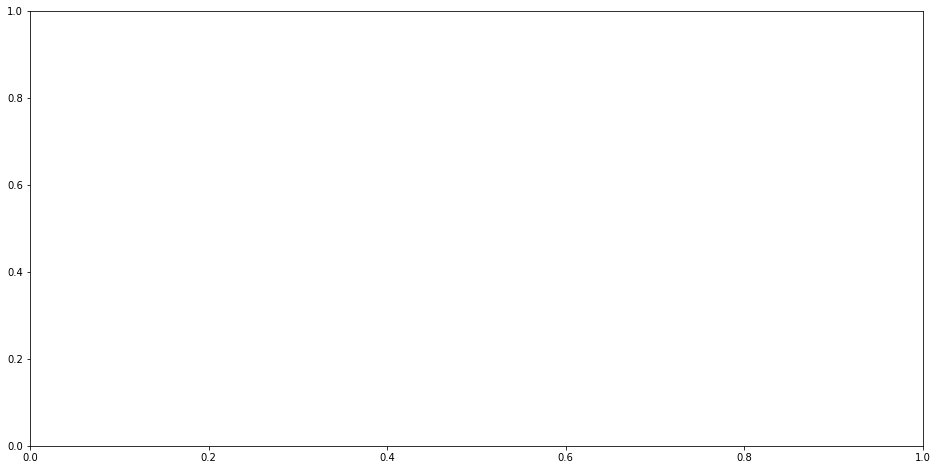

In [54]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d=np.unique(form_prob[:,0])
ax1.hist(form_prob[:, 0], bins=d.size, edgecolor='black', normed=1)

In [55]:
# Formation control
formation_prob_controls = form_prob[:, -1]
print formation_prob_controls.shape

IndexError: too many indices for array

NameError: name 'formation_prob_controls' is not defined

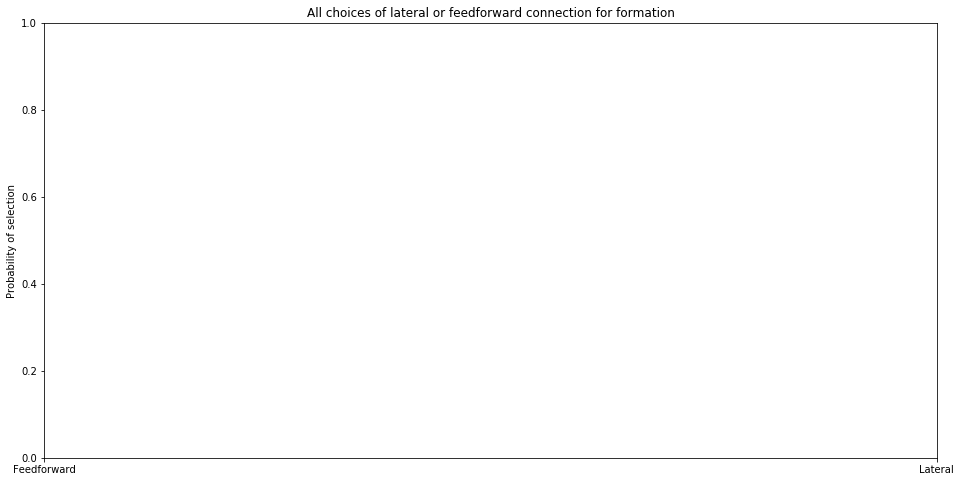

In [56]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("All choices of lateral or feedforward connection for formation")
plt.xticks([0, 1], ["Feedforward", "Lateral"])
ax1.set_ylabel("Probability of selection")
d = np.unique(formation_prob_controls)
ax1.hist(formation_prob_controls, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

In [57]:
actual_formation_controls = formations[:, 2]
print actual_formation_controls.shape

 (391L,)


(array([ 0.74168798,  0.25831202]),
 array([-0.5,  0.5,  1.5]),
 <a list of 2 Patch objects>)

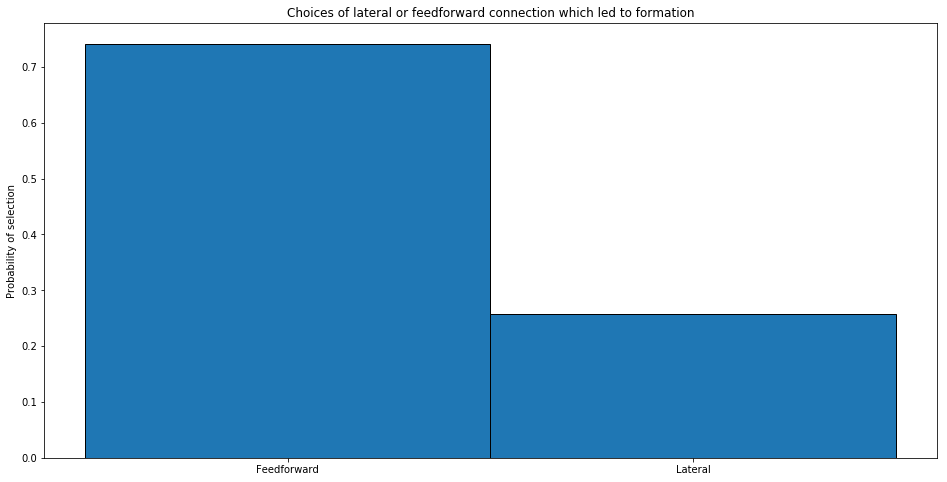

In [58]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Choices of lateral or feedforward connection which led to formation")
plt.xticks([0, 1], ["Feedforward", "Lateral"])
ax1.set_ylabel("Probability of selection")
d = np.unique(actual_formation_controls)
ax1.hist(actual_formation_controls, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

(array([ 0.74168798,  0.25831202]),
 array([-0.5,  0.5,  1.5]),
 <a list of 2 Patch objects>)

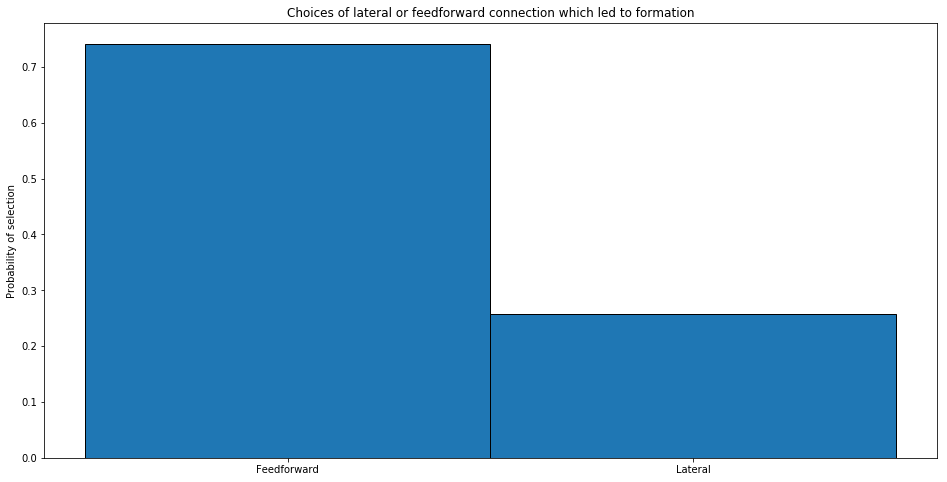

In [59]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Choices of lateral or feedforward connection which led to formation")
plt.xticks([0, 1], ["Feedforward", "Lateral"])
ax1.set_ylabel("Probability of selection")
d = np.unique(actual_formation_controls)
ax1.hist(actual_formation_controls, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

In [60]:
# sanity checks -- the times in rem_fails and form_fails do not repeat and monotonically increase

In [61]:
sorted_rem_fails = np.sort(rem_fails)
assert all(np.diff(sorted_rem_fails) > 0)

In [62]:
sorted_form_fails = np.sort(form_fails)
assert all(np.diff(sorted_form_fails) > 0)

In [63]:
sorted_form_fails[1]

19229

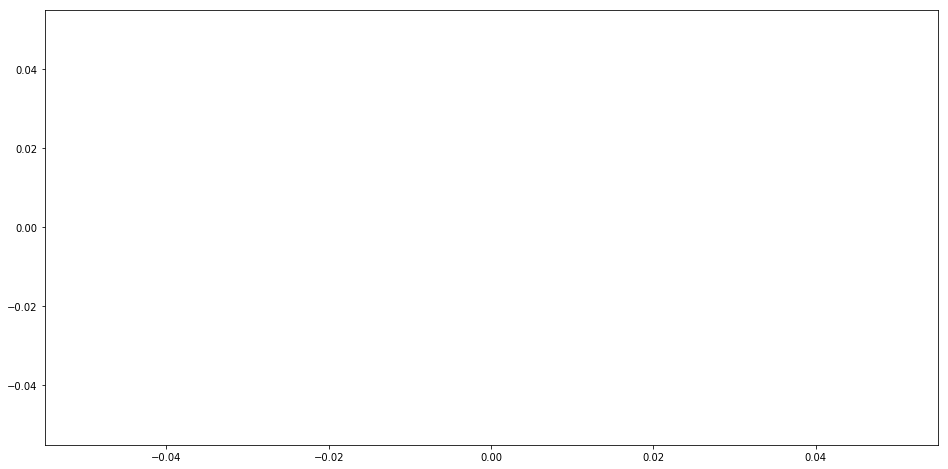

In [64]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.plot(rem_fails)

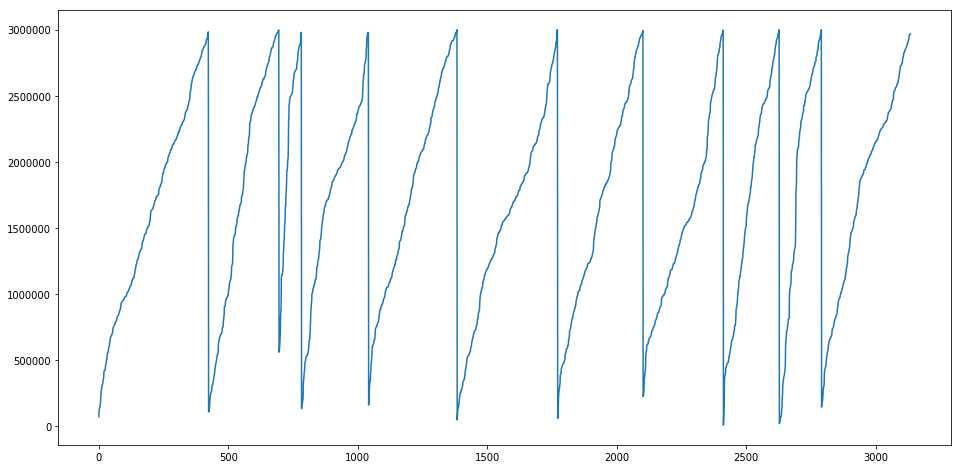

In [65]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.plot(form_fails)

In [66]:
rem_fails.size 

0

In [67]:
form_fails.size

3135

In [68]:
oob.shape[0]

3135L

In [69]:
total_failures = rem_fails.size  + form_fails.size + oob.shape[0]

In [70]:
print "RM percentage failures of total failures", rem_fails.size * 100. / total_failures

RM percentage failures of total failures 0.0


In [71]:
print "FORM percentage failures of total failures", form_fails.size * 100. / total_failures

FORM percentage failures of total failures 50.0


In [72]:
print "OOB percentage failures of total failures", oob.shape[0] * 100. / total_failures

OOB percentage failures of total failures 50.0


In [73]:
for key in files_based_removals.keys():
    times = np.asarray(files_based_removals[key])
    assert all(np.diff(times) > 0)

In [74]:
for key in files_based_removals.keys():
    times = np.asarray(files_based_formations[key])
    assert all(np.diff(times) > 0)

In [75]:
# check if putting together all times I can reconstruct the entire simulations 
hardcoded_simtime = 30000000
all_times = np.arange(hardcoded_simtime)

In [76]:
assert all(all_times - np.sort(sr_attempts[:,0]) ==0)
assert all(np.diff(np.sort(sr_attempts[:,0])) > 0)

ValueError: operands could not be broadcast together with shapes (30000000,) (2999967,) 

In [77]:
sr_attempts.shape

(2999967L, 3L)

In [78]:
total_rewiring_attempts = sr_attempts.shape[0]

In [79]:
print "Successful removals of total rewiring attempts", (removals.shape[0] * 100.) / total_rewiring_attempts

Successful removals of total rewiring attempts 0.0147001617018


In [80]:
print "Successful formations of total rewiring attempts", formations.shape[0] * 100. / total_rewiring_attempts

Successful formations of total rewiring attempts 0.0130334767016


In [81]:
print "Total percentage of failure to rewire:", total_failures * 100. / total_rewiring_attempts

Total percentage of failure to rewire: 0.209002299025


(array([ 0.46995192,  0.        ,  0.53004808]),
 array([-0.5,  0.5,  1.5,  2.5]),
 <a list of 3 Patch objects>)

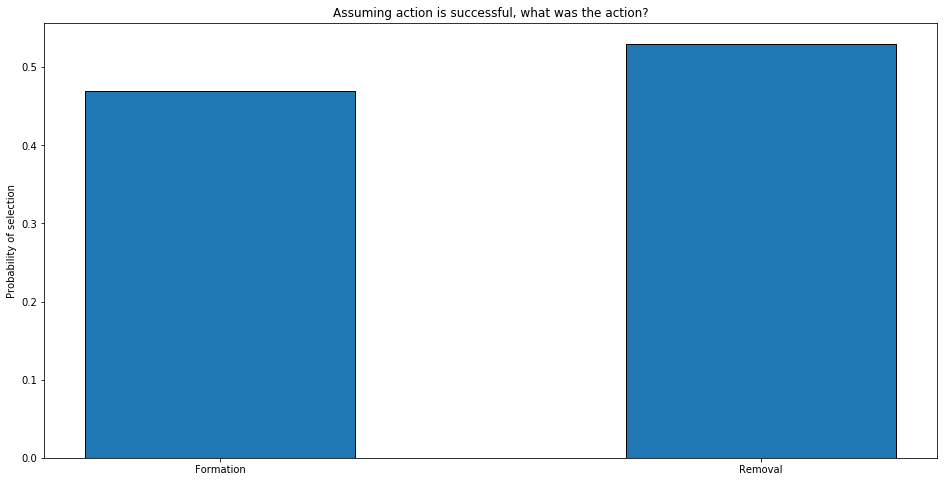

In [82]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
wombo_combo = np.concatenate((np.zeros(formations.shape[0]), np.ones(removals.shape[0])))
ax1.set_title("Assuming action is successful, what was the action?")
plt.xticks([0, 2], ["Formation", "Removal"])
ax1.set_ylabel("Probability of selection")
d = np.unique(wombo_combo*2)
ax1.hist(wombo_combo*2, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

In [83]:
# Plot selection counts per connection type

In [84]:
ff_formations = formations[formations[:,2] == 0]
lat_formations = formations[formations[:,2] == 1]

In [85]:
ff_removals = removals[removals[:,2] == 0]
lat_removals = removals[removals[:,2] == 1]

In [86]:
kek = [ff_formations, lat_formations, ff_removals, lat_removals]
silly_list = np.array([])
i=0
for k in kek:
    print k.shape
    silly_list = np.concatenate((silly_list, np.ones(k.shape[0]) * i))
    i += 1

(290L, 4L)
(101L, 4L)
(220L, 4L)
(221L, 4L)


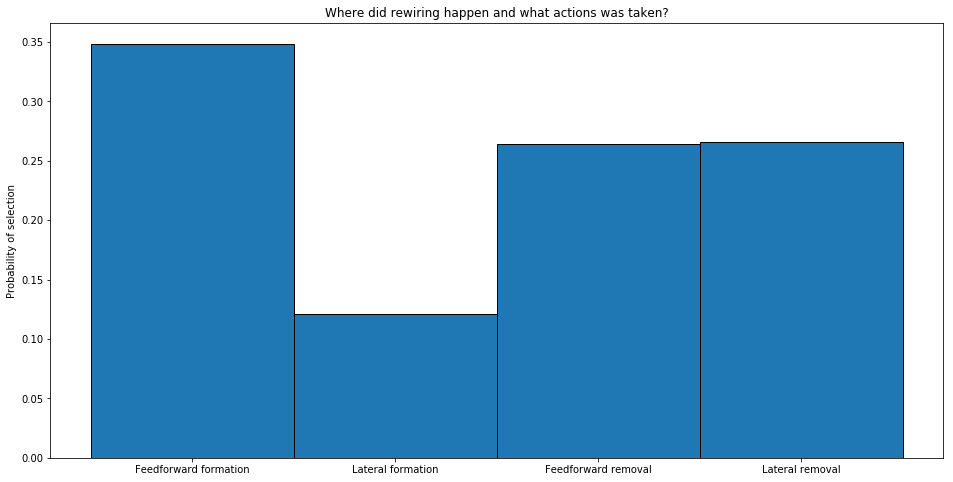

In [312]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Where did rewiring happen and what actions was taken?")
d = np.unique(silly_list)
plt.xticks(np.arange(np.max(d)+2), ["Feedforward formation", "Lateral formation", "Feedforward removal", "Lateral removal"])
ax1.set_ylabel("Probability of selection")
ax1.hist(silly_list, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)
plt.savefig("rewire_hist.png")

IndexError: too many indices for array

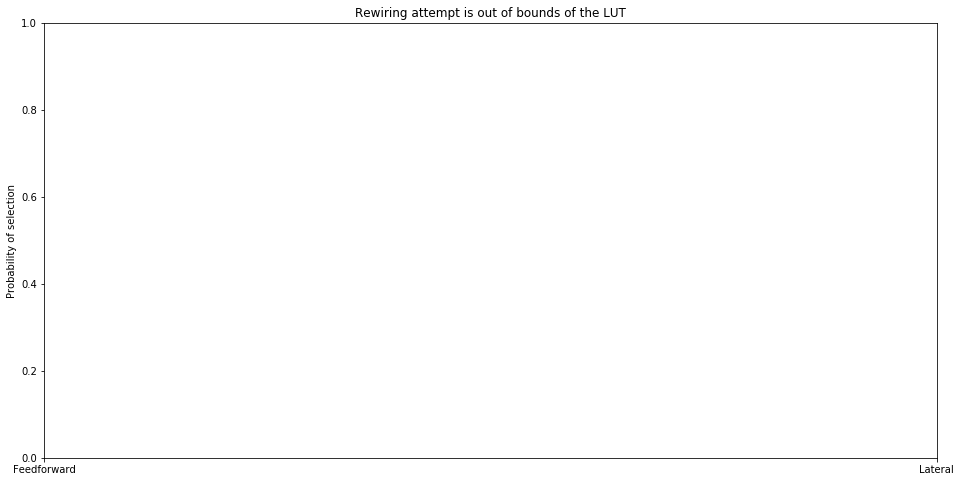

In [313]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Rewiring attempt is out of bounds of the LUT")
plt.xticks([0, 2], ["Feedforward", "Lateral"])
ax1.set_ylabel("Probability of selection")
d = np.unique(oob[:, 2]*2)
ax1.hist(oob[:, 2]*2, bins=np.arange(np.max(d)+2)-.5, edgecolor='black', normed=True)

In [314]:
print "out of a total of", oob.shape[0], " occurances of oob, ", np.count_nonzero(oob[:, 2]==1), " have been from lateral connections"
print "that is",  np.count_nonzero(oob[:, 2]==1) * 100. / oob.shape[0], "%"

out of a total of 0  occurances of oob, 

IndexError: too many indices for array

In [315]:
ff_dists = np.sqrt(dist_sq_control[dist_sq_control[:, 1] == 0])[:, 0]
lat_dists = np.sqrt(dist_sq_control[dist_sq_control[:, 1] == 1])[:, 0]
print "dist_sq_control size", dist_sq_control.shape[0]
print "ff_dists size", ff_dists.shape[0]
print "lat_dists size", lat_dists.shape[0]
print "ff + lat dist size", ff_dists.shape[0] + lat_dists.shape[0]
# dist_sq_control

 dist_sq_control size 2992863
ff_dists size 2443463
lat_dists size 549400
ff + lat dist size 2992863


In [316]:
# combine presynaptic app with subpop
# f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
# combo = np.concatenate((lat_dists * 100, ff_dists))

# d = np.unique(combo)
# ax1.hist(combo, bins=np.arange(np.max(combo)+2)-.5, edgecolor='black')
# ax1.set_xlabel("Feedforward distances {:110s} Lateral distances".format(' '))
# plt.xticks(np.concatenate((np.unique(combo[combo < np.mean(combo)]), np.unique(combo[combo > np.mean(combo)]))), np.concatenate((np.unique(combo[combo < np.mean(combo)]), np.unique(combo[combo > np.mean(combo)])-np.min(combo[combo > np.mean(combo)]))))

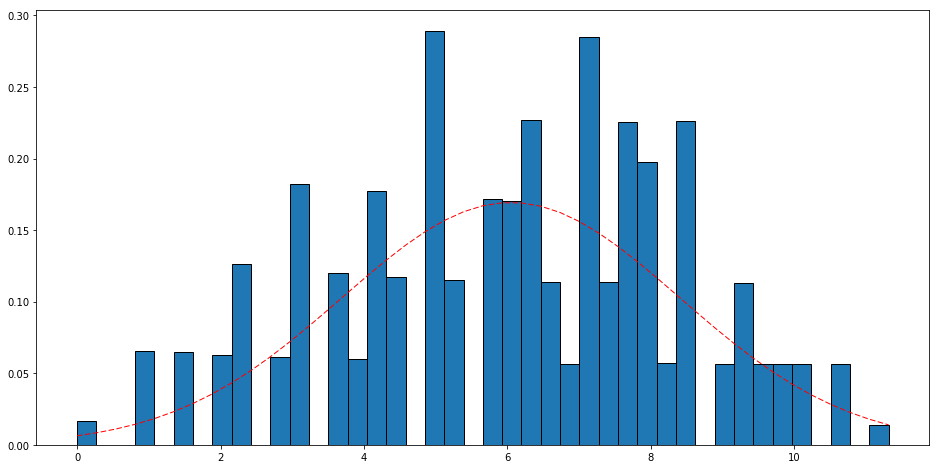

In [317]:
import matplotlib.mlab as mlab
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(ff_dists)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

n, bins, patches = ax1.hist(ff_dists, bins=d.size,normed=1, edgecolor='black')
y = mlab.normpdf( bins, m, std)
l = ax1.plot(bins, y, 'r--', linewidth=1)

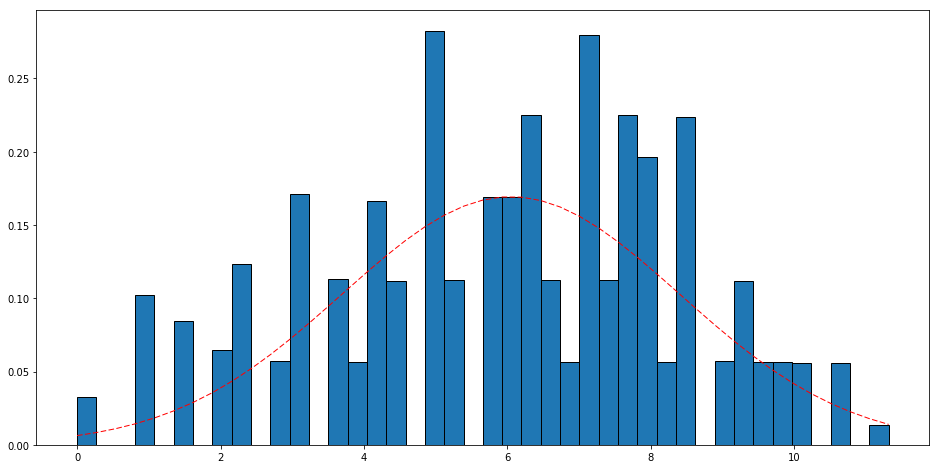

In [318]:
import matplotlib.mlab as mlab
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
d = np.unique(lat_dists)
# data = np.asarray(pre_subpops)
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

n, bins, patches = ax1.hist(lat_dists, bins=d.size,normed=1, edgecolor='black')
y = mlab.normpdf( bins, m, std)
l = ax1.plot(bins, y, 'r--', linewidth=1)

(array([ 0.81642995,  0.18357005]),
 array([ 0.,  1.,  2.]),
 <a list of 2 Patch objects>)

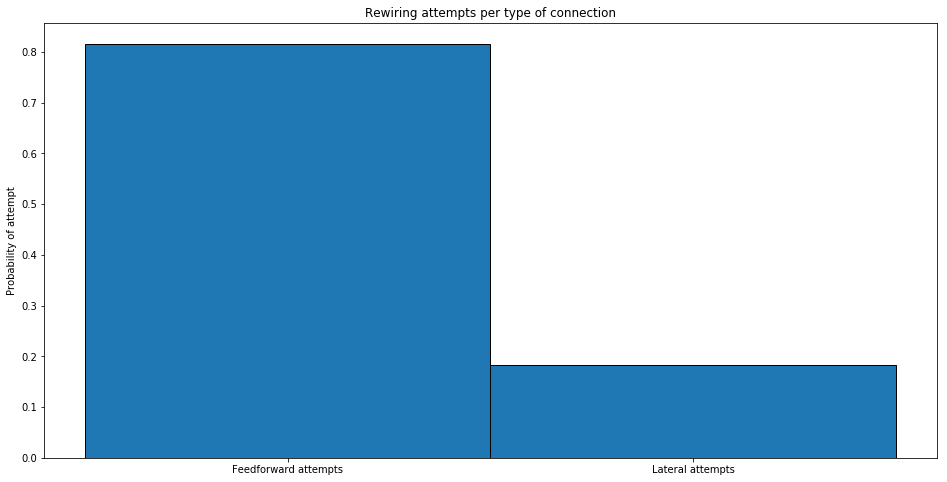

In [319]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Rewiring attempts per type of connection")
d = np.unique(sr_attempts[:,1])
plt.xticks(d+.5, ["Feedforward attempts", "Lateral attempts"])
ax1.set_ylabel("Probability of attempt")
ax1.hist(sr_attempts[:,1], bins=d.size, edgecolor='black', normed=True, range=(0, 2))

In [320]:
oob

array([], dtype=float64)

In [321]:
sr_attempts.shape[0]

2992863L

In [322]:
sr_attempts[:,2]

array([1, 1, 1, ..., 0, 0, 0])

In [323]:
existence = np.zeros(2)

In [324]:
for e in sr_attempts[:,2]:
    existence[e] += 1

In [325]:
existence

array([ 2913373.,    79490.])

In [326]:
plt.bar(existence)

TypeError: bar() takes at least 2 arguments (1 given)

In [410]:
# plot error appearance over time and show how rewires are affected by this
errors.keys()

['[ERROR]   (topographic_map_impl.c: 491): FAIL Search\n']

In [411]:
fail_times = errors['[ERROR]   (topographic_map_impl.c: 491): FAIL Search\n']

(array([  1.,   1.,   5.,   2.,   5.,   3.,   4.,   3.,   7.,   5.,   6.,
          7.,   5.,  10.,  13.,  11.,   8.,  16.,  12.,   9.,  12.,   8.,
         13.,  15.,  14.,  14.,  19.,  15.,   8.,  13.,  13.,  17.,  19.,
         17.,  20.,  16.,  25.,  17.,  16.,  16.,  19.,  18.,  17.,  14.,
         25.,  14.,  19.,  27.,  27.,  21.,  21.,  25.,  22.,  27.,  26.,
         17.,  23.,  17.,  19.,  26.,  20.,  17.,  27.,  27.,  32.,  26.,
         18.,  27.,  27.,  24.,  29.,  31.,  26.,  31.,  26.,  22.,  26.,
         21.,  25.,  30.,  26.,  30.,  22.,  22.,  26.,  28.,  27.,  31.,
         23.,  30.,  35.,  35.,  23.,  18.,  26.,  30.,  27.,  21.,  34.,
         29.]),
 array([   85977.  ,   115102.63,   144228.26,   173353.89,   202479.52,
          231605.15,   260730.78,   289856.41,   318982.04,   348107.67,
          377233.3 ,   406358.93,   435484.56,   464610.19,   493735.82,
          522861.45,   551987.08,   581112.71,   610238.34,   639363.97,
          668489.6 ,   697

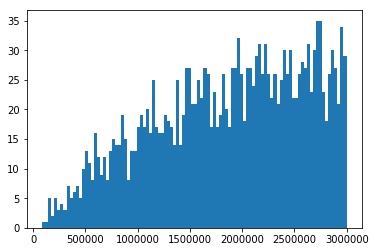

In [332]:
plt.hist(formations[:, -1], 3000000/30000)

(array([ 10.,  11.,   9.,   6.,   7.,   9.,  12.,   6.,  11.,   9.,  10.,
          5.,   8.,   5.,   8.,   6.,   8.,   4.,   4.,   8.,   7.,   4.,
          9.,   6.,  10.,  12.,  10.,   3.,  10.,   7.,   1.,   6.,  11.,
          9.,   3.,   7.,   8.,   8.,   5.,  13.,   6.,   7.,   6.,   6.,
          9.,   7.,   7.,  11.,   5.,  10.,  10.,   6.,   6.,   4.,   8.,
          8.,   2.,   7.,   4.,  10.,   4.,   3.,   7.,  11.,   4.,  11.,
          6.,   6.,   7.,  11.,   9.,   5.,  11.,   6.,   5.,   9.,   8.,
          9.,   5.,   4.,   9.,  10.,   8.,   7.,   7.,   7.,   7.,  12.,
          5.,   8.,   7.,   6.,   9.,   5.,   8.,   5.,   9.,   5.,   7.,
          8.,   7.,   7.,   8.,   7.,   7.,   2.,   6.,   6.,   5.,   8.,
          5.,   6.,  11.,   4.,   7.,   7.,   6.,   5.,   6.,   4.,   9.,
          3.,   2.,  10.,   3.,   5.,   6.,   5.,   6.,   6.,   6.,   5.,
          5.,   5.,   6.,   6.,   5.,   4.,   7.,   7.,   7.,   9.,   7.,
          4.,   8.,   7.,  11.,   6., 

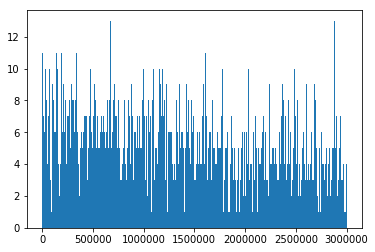

In [333]:
plt.hist(removals[:, -1], 30000000/30000)

(array([  4.,   2.,   3.,   3.,   9.,   1.,   7.,   3.,   9.,  10.,   5.,
          9.,  10.,  15.,   5.,  10.,  15.,  16.,   8.,  10.,  13.,   8.,
          8.,  16.,  15.,  10.,  10.,  13.,  21.,  25.,  14.,  22.,  14.,
         18.,  18.,  16.,  18.,  10.,  29.,  22.,  20.,  10.,  19.,  21.,
         24.,  22.,  22.,  26.,  16.,  19.,  26.,  19.,  24.,  27.,  20.,
         32.,  15.,  24.,  23.,  22.,  22.,  23.,  28.,  22.,  18.,  29.,
         36.,  23.,  34.,  26.,  35.,  28.,  20.,  25.,  33.,  30.,  22.,
         32.,  28.,  21.,  31.,  34.,  37.,  27.,  38.,  25.,  30.,  24.,
         21.,  26.,  36.,  29.,  25.,  32.,  30.,  30.,  29.,  22.,  27.,
         26.]),
 array([   8339.  ,   11254.58,   14170.16,   17085.74,   20001.32,
          22916.9 ,   25832.48,   28748.06,   31663.64,   34579.22,
          37494.8 ,   40410.38,   43325.96,   46241.54,   49157.12,
          52072.7 ,   54988.28,   57903.86,   60819.44,   63735.02,
          66650.6 ,   69566.18,   72481.76,   

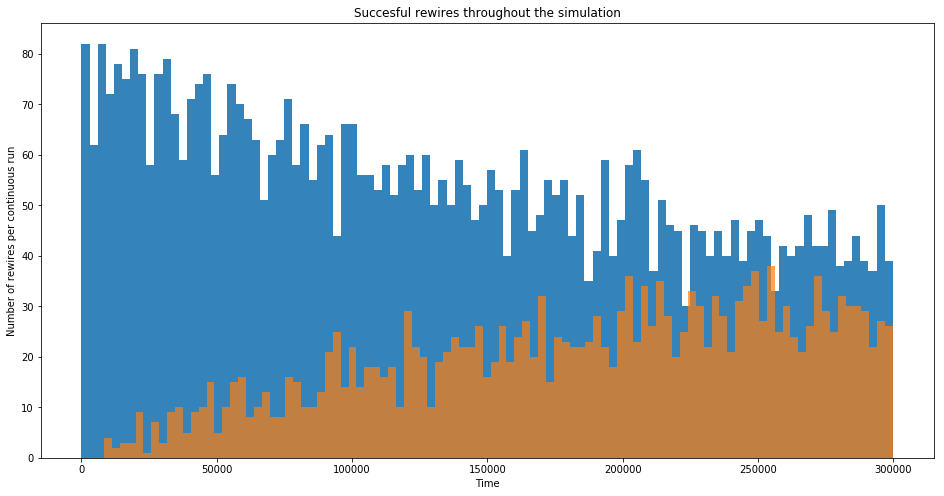

In [92]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of rewires per continuous run")
ax1.set_xlabel("Time")
ax1.hist(removals[:, -1], int(3000000/30000), alpha=.9)
ax1.hist(formations[:, -1], int(3000000/30000), alpha=.7)

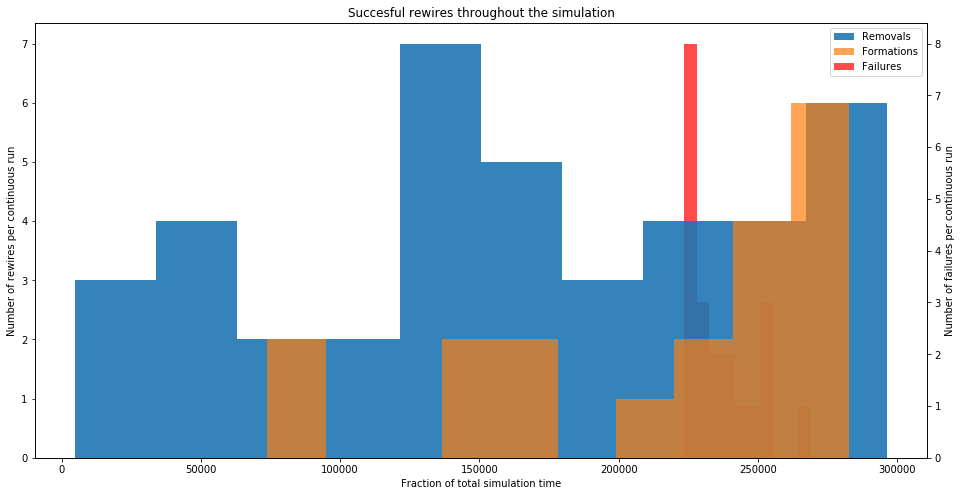

In [416]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of rewires per continuous run")
ax1.set_xlabel("Fraction of total simulation time")
ax1.set_zorder(2)
ax2 = ax1.twinx()
ax2.set_ylabel("Number of failures per continuous run")
ax1.hist(removals[:, -1]  , int(300000/30000), alpha=.9, zorder=8, label="Removals")
ax1.hist(formations[:, -1], int(300000/30000), alpha=.7, zorder=9, label="Formations")
ax2.hist(fail_times, int(300000/30000),color='r', zorder=1, alpha=.7, label="Failures")
ax2.set_zorder(1)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='best')
plt.savefig('succesful_rewires.png')

In [509]:
sr_attempts.shape[0] // 30000

1L

In [252]:
sr_attempts

array([[     49,       1,       1],
       [    109,       0,       1],
       [    139,       0,       1],
       ..., 
       [9779420,       0,       1],
       [9779580,       0,       1],
       [9779790,       0,       0]])

In [258]:
sr_attempts[:,0]

array([     49,     109,     139, ..., 9779420, 9779580, 9779790])

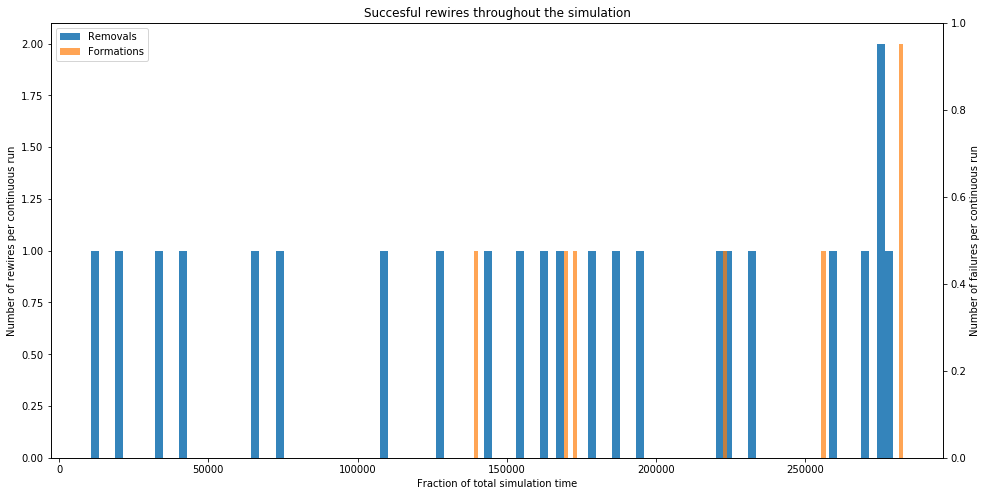

In [417]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of rewires per continuous run")
ax1.set_xlabel("Fraction of total simulation time")
ax1.set_zorder(2)
ax2 = ax1.twinx()
ax2.set_ylabel("Number of failures per continuous run")
ax1.hist(removals[removals[:,2]==0][:, -1]  , int(3000000/30000), alpha=.9, zorder=8, label="Removals")
ax1.hist(formations[formations[:,2]==0][:, -1], int(3000000/30000), alpha=.7, zorder=9, label="Formations")
# ax2.hist(fail_times, int(30000000/30000),color='r', zorder=1, alpha=.7, label="Failures")
ax2.set_zorder(1)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='best')
plt.savefig('succesful_rewires_ff.png')

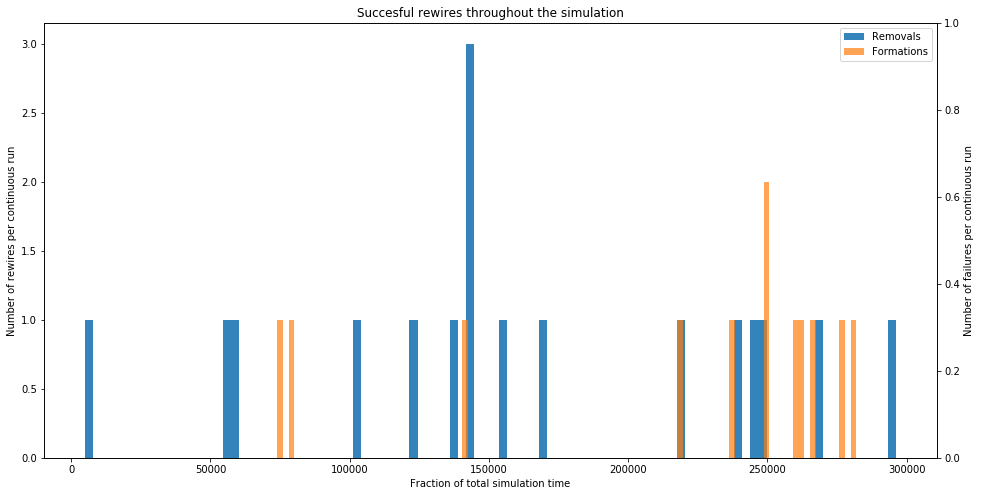

In [418]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8))
ax1.set_title("Succesful rewires throughout the simulation")
ax1.set_ylabel("Number of rewires per continuous run")
ax1.set_xlabel("Fraction of total simulation time")
ax1.set_zorder(2)
ax2 = ax1.twinx()
ax2.set_ylabel("Number of failures per continuous run")
ax1.hist(removals[removals[:,2]==1][:, -1]  , int(3000000/30000), alpha=.9, zorder=8, label="Removals")
ax1.hist(formations[formations[:,2]==1][:, -1], int(3000000/30000), alpha=.7, zorder=9, label="Formations")
# ax2.hist(fail_times, int(30000000/30000),color='r', zorder=1, alpha=.7, label="Failures")
ax2.set_zorder(1)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='best')
plt.savefig('succesful_rewires_lat.png')

In [680]:
removals

array([[     74,      78,       0,     118],
       [    184,     119,       0,     185],
       [     27,      58,       0,     245],
       ..., 
       [    207,     160,       0, 2998913],
       [     51,     129,       0, 2999005],
       [    247,     250,       0, 2999142]])

In [682]:
removals[removals[:,2]==1]

array([[     59,      60,       1,     813],
       [     51,      67,       1,     817],
       [     91,      75,       1,     944],
       ..., 
       [    120,     137,       1, 2997436],
       [    205,     222,       1, 2997541],
       [    236,     221,       1, 2997729]])